# Diffusion Model for Financial Time Series Generation

This notebook implements a diffusion-based generative model for financial time series data. It demonstrates how to train a denoising diffusion probabilistic model (DDPM) to generate synthetic stock returns that mimic the statistical properties of real financial data.

## Overview

The notebook consists of several components:

1. **Data Processing**: Loads and preprocesses financial time series data from a CSV file
2. **Model Architecture**: Implements a diffusion model with RNN backbone
3. **Training**: Uses PyTorch Lightning to train the model on historical returns
4. **Sampling**: Generates synthetic financial data from the trained model
5. **Evaluation**: Compares statistical properties between real and generated data

## Requirements

To run this notebook, you'll need:

### Python Packages
```
numpy
pandas
matplotlib
seaborn
torch
pytorch-lightning
scikit-learn
scipy
```

You can install these with:
```bash
pip install numpy pandas matplotlib seaborn torch lightning scikit-learn scipy
```

### Data
A file named `prices.csv`

 containing historical stock data with columns:
  - `vd`: Date
  - `id`: Stock identifier
  - `ret`: Returns

### Hardware

GPU is recommended for training, but not necessary

Note: training might take a significant amount of time depending on your hardware. The notebook is configured with early stopping to prevent overfitting and save the best model checkpoint.

## Diffusion Introduction

Denoising Diffusion Probabilistic Models (DDPMs) represent a powerful class of generative models that learn to create data by gradually removing noise from a random signal. Unlike other generative approaches, diffusion models work by first defining a forward process that slowly adds noise to data until it becomes pure random noise, then training a neural network to reverse this process. This reversal, called the denoising process, starts with random noise and incrementally refines it into coherent data samples. Think of it like watching a photograph slowly emerge in developing fluid - at first, you see only random patterns, but gradually a clear image takes shape. This step-by-step approach allows diffusion models to generate highly realistic data across various domains, from images to time series. What makes DDPMs particularly appealing is their stable training behavior and their ability to capture complex data distributions without the adversarial dynamics found in GANs or the complexity of autoregressive models, making them increasingly popular for generating synthetic data in fields ranging from computer vision to, as in this notebook, financial time series generation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from lightning.pytorch import LightningModule, LightningDataModule, Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from scipy import stats
from torch import nn, Tensor
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

In [2]:
FILENAME = 'prices.csv'
CKPT_PATH = 'model.ckpt'

DATE_COL = 'vd'
RETURN_COL = 'ret'
SYMBOL_COL = 'id'
MASK_COL = 'mask'

WINDOW_SIZE = 30

# Load data

In [4]:
def get_data_array(
    start_date: str='1980-01-01',
    end_date: str='2024-01-01',
    min_coverage: float=0.90,
    max_symbols: int=100,
) -> tuple[pd.DataFrame, float, float]:
    # Load data
    df = pd.read_csv(FILENAME)
    df = df.drop_duplicates()
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df[RETURN_COL] = df[RETURN_COL].clip(lower=-0.2, upper=0.2).fillna(0)

    df = df.sort_values([SYMBOL_COL, DATE_COL])

    assert df.shape[0] == df[[SYMBOL_COL, DATE_COL]].drop_duplicates().shape[0]

    # Filter data for date range
    df = df[(df[DATE_COL] >= pd.to_datetime(start_date)) & (df[DATE_COL] <= pd.to_datetime(end_date))].copy()

    # Get all unique trading days in the period
    all_trading_days = sorted(df[DATE_COL].dt.date.unique())
    print(f"Found {len(all_trading_days)} total trading days in period")

    # Calculate coverage for each symbol based on all possible trading days
    symbol_dates = df.groupby(SYMBOL_COL)[DATE_COL].count()
    symbol_coverage = {symbol: num_dates / len(all_trading_days) for symbol, num_dates in symbol_dates.items()}

    # Filter symbols with at least min_coverage
    good_symbols = [symbol for symbol, coverage in symbol_coverage.items() if coverage >= min_coverage]
    print(f"Found {len(good_symbols)} symbols with at least {min_coverage:.2%} coverage across all trading days")
    good_symbols = good_symbols[:max_symbols]

    df = df[df[SYMBOL_COL].isin(good_symbols)]

    data_std = df[RETURN_COL].std()

    df[RETURN_COL] = df[RETURN_COL] / data_std

    # Create a pivot table with only good symbols and common dates
    returns_pivot = df.pivot_table(index=DATE_COL, columns=SYMBOL_COL, values=RETURN_COL)
    returns_pivot = returns_pivot.reset_index()

    returns_pivot = returns_pivot.set_index(DATE_COL)

    return returns_pivot, data_std

df, data_std = get_data_array()

Found 10680 total trading days in period
Found 100 symbols with at least 90.00% coverage across all trading days


# Data module

In [5]:
def extract_time_features(date: pd.DatetimeIndex | pd.Series) -> np.ndarray:
    if isinstance(date, pd.Series):
        date = date.dt
    return np.stack([
        ((date.year - 1980) / (2024 - 1980)).values,
        (date.quarter / 4).values,
        (date.month / 12).values,
        (date.day / 31).values,
        (date.weekday / 5).values,
    ], -1)

class SlidingWindowDataset(Dataset):
    def __init__(self, X, mask, date, window_size):
        super().__init__()
        self.X = torch.from_numpy(X).float()
        self.mask = torch.from_numpy(mask).float()
        self.date = torch.from_numpy(date).float()
        self.window_size = window_size

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.window_size],
            self.mask[idx:idx+self.window_size],
            self.date[idx:idx+self.window_size],
        )

    def __len__(self):
        return len(self.X) - self.window_size

class SlidingWindowDatamodule(LightningDataModule):
    def __init__(
        self,
        df: pd.DataFrame,
        window_size: int,
        batch_size: int,
        train_ratio: float = 0.8,
        val_ratio: float = 0.2,
    ):
        super().__init__()
        self.window_size = window_size
        self.batch_size = batch_size

        self.df = df
        self.X = self.df.values
        self.date = self.df.index

        self.mask = (self.X != 0) & np.isfinite(self.X)
        self.X = np.nan_to_num(self.X, nan=0.0, posinf=0.0, neginf=0.0)

        date = extract_time_features(self.date)

        train_ind = int(train_ratio * len(self.X))
        val_ind = int((train_ratio + val_ratio) * len(self.X))

        self.dim = self.X.shape[1]
        self.num_time_features = date.shape[1]

        self.trainset = SlidingWindowDataset(self.X[:train_ind], self.mask[:train_ind], date[:train_ind], window_size)
        self.valset = SlidingWindowDataset(self.X[train_ind:val_ind], self.mask[train_ind:val_ind], date[train_ind:val_ind], window_size)
        self.testset = SlidingWindowDataset(self.X[val_ind:], self.mask[val_ind:], date[val_ind:], window_size)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.trainset, self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valset, self.batch_size, shuffle=False, num_workers=0)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.testset, self.batch_size, shuffle=False, num_workers=0)

# Model

In [6]:
class RNN(nn.Module):
    def __init__(
        self,
        in_dim: int,
        num_time_features: int,
        hidden_dim: int,
        num_layers: int,
        num_diffusion_steps: int,
    ):
        super().__init__()
        self.diffusion_ind_emb = nn.Embedding(num_diffusion_steps, hidden_dim)
        self.dt_features_emb = nn.Linear(num_time_features, hidden_dim)

        self.rnn = nn.GRU(
            input_size=in_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )

        self.net = nn.Sequential(
            nn.Linear(3 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim),
        )

    def forward(
        self,
        x: Tensor,
        dt_features: Tensor,
        diffusion_ind: Tensor,
    ) -> Tensor:
        """
        x: (B, T, D)
        dt_features: (B, T, N)
        diffusion_ind: (B, T)
        """
        i = self.diffusion_ind_emb(diffusion_ind)
        t = self.dt_features_emb(dt_features)

        x, _ = self.rnn(x)
        x = torch.cat([x, i, t], dim=-1)
        return self.net(x)

In [7]:
class DDPMModel(nn.Module):
    """
    A simple DDPM model that predicts the noise added to the data.
    It takes the noisy data and the time step as input, and outputs the predicted noise.

    Args:
        linear_start (float): The starting value for the linear beta schedule.
        linear_end (float): The ending value for the linear beta schedule.
        n_timestep (int): The number of diffusion steps.
        net (nn.Module): The neural network to predict noise.
        beta_schedule (str): The type of beta schedule ('linear' or 'cosine').
    """
    def __init__(
        self,
        *,
        linear_start: float = None,
        linear_end: float = None,
        n_timestep: int = None,
        net: nn.Module = None,
        beta_schedule: str = 'linear',
    ) -> None:
        super().__init__()
        self.n_timestep = n_timestep
        self.net = net

        if beta_schedule == 'linear':
            betas = torch.linspace(linear_start, linear_end, n_timestep)
            alphas = torch.cumprod(1 - betas, dim=0)
        elif beta_schedule == 'cosine':
            # We don't need linear_start and linear_end here
            cosine_s = 0.008

            ts = torch.arange(n_timestep + 1)
            alphas_bar = torch.cos((ts / n_timestep + cosine_s) / (1 + cosine_s) * torch.pi / 2)**2
            alphas_bar = alphas_bar / alphas_bar.max()

            betas = 1 - alphas_bar[1:] / alphas_bar[:-1]
            betas = torch.clip(betas, 0.0001, 0.9999)
            alphas = torch.cumprod(1 - betas, dim=0)

        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)

    def q_sample(
        self,
        step: Tensor, # [..., 1]
        x: Tensor, # [..., dim]
    ) -> tuple[Tensor, Tensor]: # each [..., dim]
        noise = torch.randn_like(x)
        alpha = self.alphas[step.long()]
        x_noisy = alpha.sqrt() * x + (1 - alpha).sqrt() * noise
        return x_noisy, noise

    @torch.no_grad()
    def sample_step(
        self,
        step: int,
        x: Tensor, # [..., dim]
        dt_features: Tensor # [..., hidden_dim]
    ) -> Tensor: # [..., dim]
        alpha_prod_t = self.alphas[step]
        alpha_prod_t_prev = self.alphas[step - 1] if step > 0 else torch.tensor(1.0).to(x)
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        t = torch.ones_like(x[...,0]) * step
        pred_noise = self.net(x, diffusion_ind=t.long(), dt_features=dt_features)

        pred_original_sample = (x - beta_prod_t.sqrt() * pred_noise) / alpha_prod_t.sqrt()

        pred_original_sample_coeff = (alpha_prod_t_prev.sqrt() * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t.sqrt() * beta_prod_t_prev / beta_prod_t

        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * x

        if step > 0:
            z = torch.randn_like(x)
            variance = ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t).sqrt() * z
            pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    @torch.no_grad()
    def sample(
        self,
        x: Tensor,
        dt_features: Tensor,
        **kwargs,
    ) -> Tensor:
        sample = self.sample_traj(
            x=x,
            dt_features=dt_features,
            traj_steps=1,
        )
        return sample[-1]

    @torch.no_grad()
    def sample_traj(
        self,
        x: Tensor,
        dt_features: Tensor,
        traj_steps: int = 10,
        **kwargs,
    ) -> Tensor:
        x = torch.randn_like(x)
        traj = [x]
        for diff_step in reversed(range(0, self.n_timestep)):
            x = self.sample_step(diff_step, x, dt_features=dt_features)
            traj.append(x)
        traj = torch.stack(traj, dim=0)
        ind = torch.linspace(0, self.n_timestep - 1, max(2, traj_steps)).round().long()
        return traj[ind]

    def get_loss(
        self,
        target: Tensor,
        dt_features: Tensor,
        **kwargs,
    ) -> tuple[Tensor, Tensor]:
        diffusion_ind = torch.randint_like(target[...,:1], 0, self.n_timestep).long()

        xt, noise = self.q_sample(step=diffusion_ind, x=target)
        pred = self.net(x=xt, diffusion_ind=diffusion_ind.squeeze(-1), dt_features=dt_features)

        alpha = self.alphas[diffusion_ind]
        pred_x0 = (xt - (1 - alpha).sqrt() * pred) / alpha.sqrt()

        loss = (pred - noise)**2
        return loss, pred_x0

In [8]:
class DiffusionModule(LightningModule):
    def __init__(self, dim: int, num_time_features: int, window_size: int) -> None:
        super().__init__()
        self.window_size = window_size
        self.dim = dim
        self.num_time_features = num_time_features
        self.save_hyperparameters()

        self.model = DDPMModel(
            linear_start=1e-4,
            linear_end=0.2,
            n_timestep=100,
            net=RNN(
                in_dim=dim,
                num_time_features=num_time_features,
                hidden_dim=512,
                num_diffusion_steps=100,
                num_layers=1,
            ),
            beta_schedule='linear',
        )

    def training_step(self, batch, batch_idx, log_name='train_loss'):
        x, mask, dt_features = batch
        loss = self.model.get_loss(x, dt_features=dt_features)[0]
        loss = (loss * mask).sum() / mask.sum()
        self.log(log_name, loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        self.training_step(batch, batch_idx, 'val_loss')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=1000)
        return [optimizer], [scheduler]

    @torch.no_grad()
    def sample(self, dt_features: np.ndarray) -> Tensor:
        t = torch.from_numpy(dt_features).float().to(self.device)

        x = torch.randn(*t.shape[:-1], self.dim).to(self.device)
        x = self.model.sample(x, dt_features=t)

        return x

# Train

In [9]:
datamodule = SlidingWindowDatamodule(
    df=df,
    window_size=WINDOW_SIZE,
    batch_size=256,
)

module = DiffusionModule(
    dim=datamodule.dim,
    num_time_features=datamodule.num_time_features,
    window_size=datamodule.window_size,
)

### Load pre-trained model if available

In [10]:
module = DiffusionModule.load_from_checkpoint(CKPT_PATH)

### Train model from scratch

Note: skip this if you have a pre-trained model

In [ ]:
np.random.seed(123)
torch.manual_seed(123)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-5,
    patience=200,
    verbose=False,
    mode='min',
)
checkpoint_cb = ModelCheckpoint(
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)
trainer = Trainer(
    accelerator='auto',
    max_epochs=1000,
    callbacks=[early_stop_cb, checkpoint_cb],
    check_val_every_n_epoch=1,
    enable_progress_bar=True,
)
trainer.fit(module, datamodule.train_dataloader(), val_dataloaders=datamodule.val_dataloader())
module = DiffusionModule.load_from_checkpoint(checkpoint_cb.best_model_path)

# Sample new sequences

In [11]:
def extract_consecutive_date_sequences(df, window_size, stride=10):
    sequences = []
    datetime_features = []

    for i in range(0, len(df) - window_size + 1, stride):
        date_seq = df[i:i+window_size].index
        sequences.append(date_seq)

        features = extract_time_features(date_seq)
        datetime_features.append(features)

    return sequences, np.array(datetime_features)

In [12]:
seq, dt_features = extract_consecutive_date_sequences(df, window_size=WINDOW_SIZE, stride=WINDOW_SIZE)

x = module.sample(dt_features).detach().cpu().numpy()
flattened_dates = np.array([date for seq_dates in seq for date in seq_dates])
df_sample = pd.DataFrame(x.reshape(-1, x.shape[-1]), columns=df.columns, index=flattened_dates)

# Unscale the data
df_true = df.copy() * data_std
df_sample = df_sample * data_std

# Evaluation

In [13]:
def analyze_financial_data(df_true, df_sample, num_symbols_to_show=20):
    """
    Analyze and compare real and generated financial time series data

    Args:
        df_true: DataFrame with date index and returns as columns
        df_sample: DataFrame with date index and returns as columns
        num_symbols_to_show: Number of symbols to include in correlation heatmap
    """
    # Convert DataFrames to numpy arrays for processing
    real_data = df_true.values
    generated_data = df_sample.values

    # Get column names (symbols)
    symbols = df_true.columns.tolist()

    # Make sure dimensions match
    if real_data.shape[1] != generated_data.shape[1]:
        raise ValueError(f"Number of symbols don't match: {real_data.shape[1]} vs {generated_data.shape[1]}")

    # Ensure data is of the same length for comparison
    min_length = min(real_data.shape[0], generated_data.shape[0])
    real_data = real_data[:min_length]
    generated_data = generated_data[:min_length]
    dates = df_true.index[:min_length]

    # 1. Plot random samples
    plot_random_samples(real_data, generated_data, dates, symbols, num_samples=5)

    # 2. Correlation analysis
    plot_correlation_comparison(real_data, generated_data, symbols, num_symbols_to_show)

    # 3. Empirical density
    plot_density_comparison(real_data, generated_data)

    # 4. PCA components
    plot_pca_comparison(real_data, generated_data)


def plot_correlation_comparison(real_data, generated_data, symbols, num_symbols_to_show=20):
    """Plot correlation heatmaps for real and generated data, plus their absolute error"""
    plt.figure(figsize=(24, 8))

    # Select a subset of symbols to make the heatmap readable
    if len(symbols) > num_symbols_to_show:
        idx = np.random.choice(len(symbols), num_symbols_to_show, replace=False)
        selected_symbols = [symbols[i] for i in idx]
    else:
        idx = np.arange(len(symbols))
        selected_symbols = symbols

    # Calculate correlations - use pandas for NaN handling
    real_df = pd.DataFrame(real_data[:, idx], columns=selected_symbols)
    gen_df = pd.DataFrame(generated_data[:, idx], columns=selected_symbols)

    real_corr = real_df.corr().fillna(0)
    gen_corr = gen_df.corr()

    # Calculate absolute error between correlation matrices
    corr_abs_error = np.abs(real_corr - gen_corr)

    # Plot real data correlation
    plt.subplot(1, 3, 1)
    sns.heatmap(real_corr, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
    plt.title('Real Data Symbol Correlation')

    # Plot generated data correlation
    plt.subplot(1, 3, 2)
    sns.heatmap(gen_corr, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
    plt.title('Generated Data Symbol Correlation')

    # Plot absolute error between correlation matrices
    plt.subplot(1, 3, 3)
    sns.heatmap(corr_abs_error, cmap='Reds', vmin=0, vmax=1, annot=False)
    plt.title('Absolute Error in Correlation Matrix')

    plt.tight_layout()
    plt.show()

    # Calculate and print correlation similarity metrics
    corr_difference = np.abs(real_corr.values - gen_corr.values).mean()
    print(f"Mean absolute correlation difference: {corr_difference:.4f}")

    # Calculate correlation between the two correlation matrices
    corr_similarity = np.corrcoef(real_corr.values.flatten(), gen_corr.values.flatten())[0, 1]
    print(f"Correlation between correlation matrices: {corr_similarity:.4f}")

    # Additional metrics on the error
    print(f"Max absolute error in correlations: {np.max(corr_abs_error.values):.4f}")
    print(f"Median absolute error in correlations: {np.median(corr_abs_error.values):.4f}")


def plot_density_comparison(real_data, generated_data):
    """Plot overlapping empirical density distributions showing only edges"""
    clip_val = 0.2

    # Create a single figure
    plt.figure(figsize=(6, 3))

    # Flatten data for distribution analysis, removing NaNs
    real_flat = real_data.flatten()
    real_flat = real_flat[~np.isnan(real_flat)]  # Remove NaNs
    real_flat = real_flat.clip(-clip_val, clip_val)  # Clip after removing NaNs

    gen_flat = generated_data.flatten()
    gen_flat = gen_flat[~np.isnan(gen_flat)]  # Remove NaNs (if any)
    gen_flat = gen_flat.clip(-clip_val, clip_val)

    # Define common bins to ensure histograms are comparable
    bins = np.linspace(-clip_val, clip_val, 50)

    # Plot histograms with edge only (histtype='step')
    plt.hist(real_flat, bins=bins, histtype='step', density=True,
             linewidth=2, color='C0', label='Real Data')
    plt.hist(gen_flat, bins=bins, histtype='step', density=True,
             linewidth=2, color='C1', label='Generated Data')

    plt.title('Return Distributions Comparison')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.xlim(-clip_val, clip_val)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compare statistical properties
    print("Distribution Statistics:")
    print(f"Real data - Mean: {np.nanmean(real_flat):.6f}, Std: {np.nanstd(real_flat):.6f}")
    print(f"Generated data - Mean: {np.mean(gen_flat):.6f}, Std: {np.std(gen_flat):.6f}")

    # KS test for distribution similarity
    ks_stat, ks_pvalue = stats.ks_2samp(real_flat, gen_flat)
    print(f"Kolmogorov-Smirnov test - Statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.6f}")


def plot_pca_comparison(real_data, generated_data):
    """Compute and plot PCA components and explained variance"""
    # Create copies to avoid modifying original data
    real_data_for_pca = real_data.copy()
    generated_data_for_pca = generated_data.copy()

    # Replace NaNs with 0 as requested
    real_data_for_pca = np.nan_to_num(real_data_for_pca, nan=0.0)
    generated_data_for_pca = np.nan_to_num(generated_data_for_pca, nan=0.0)

    # Compute PCA for real data
    pca_real = PCA(n_components=4)
    pca_real.fit(real_data_for_pca)

    # Compute PCA for generated data
    pca_gen = PCA(n_components=4)
    pca_gen.fit(generated_data_for_pca)

    # Create data for explained variance bar plot
    explained_var_data = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(4)] * 2,
        'Explained Variance': list(pca_real.explained_variance_ratio_[:4]) +
                             list(pca_gen.explained_variance_ratio_[:4]),
        'Source': ['Real Data'] * 4 + ['Generated Data'] * 4
    })

    plt.figure(figsize=(12, 6))
    # Create bar plot for explained variance
    sns.barplot(x='Component', y='Explained Variance', hue='Source', data=explained_var_data)
    plt.title('PCA Explained Variance Comparison')
    plt.ylabel('Explained Variance Ratio')
    plt.legend(title='')
    plt.tight_layout()
    plt.show()

    # Print explained variance
    print("PCA Explained Variance:")
    print(f"Real data: {pca_real.explained_variance_ratio_[:4].round(4)}")
    print(f"Generated data: {pca_gen.explained_variance_ratio_[:4].round(4)}")

    # Calculate total explained variance for first 4 components
    real_total = pca_real.explained_variance_ratio_[:4].sum()
    gen_total = pca_gen.explained_variance_ratio_[:4].sum()
    print("Total explained variance (first 4 components):")
    print(f"Real data: {real_total:.4f} ({real_total*100:.1f}%)")
    print(f"Generated data: {gen_total:.4f} ({gen_total*100:.1f}%)")


def plot_random_samples(real_data, generated_data, dates, symbols, num_samples=5, num_timesteps=50):
    """Plot random samples from real and generated data with shared y-axes"""
    # Create a figure with a grid of subplots that share y-axes between pairs
    _, axes = plt.subplots(num_samples, 2, figsize=(12, 8), sharey='row')

    # Select random symbols to display
    num_symbols = real_data.shape[1]
    symbol_indices = np.random.choice(num_symbols, num_samples, replace=False)
    selected_symbols = [symbols[i] for i in symbol_indices]

    # Ensure data lengths match for comparison
    min_length = min(real_data.shape[0], generated_data.shape[0])
    real_data_subset = real_data[:min_length]
    generated_data_subset = generated_data[:min_length]
    dates_subset = dates[:min_length]

    # If data is longer than num_timesteps, select a random starting point
    if min_length > num_timesteps:
        start_idx = np.random.randint(0, min_length - num_timesteps)
        real_data_subset = real_data_subset[start_idx:start_idx + num_timesteps]
        generated_data_subset = generated_data_subset[start_idx:start_idx + num_timesteps]
        dates_subset = dates_subset[start_idx:start_idx + num_timesteps]

    # Plot each selected symbol
    for i, (symbol_idx, symbol_name) in enumerate(zip(symbol_indices, selected_symbols)):
        # Plot real data
        ax_real = axes[i, 0]
        real_series = real_data_subset[:, symbol_idx]
        ax_real.plot(dates_subset, real_series)
        ax_real.set_title(f'Real Data - {symbol_name}')
        ax_real.set_xlabel('Date')
        ax_real.set_ylabel('Return')
        ax_real.grid(True)

        # Format x-axis dates nicely
        plt.setp(ax_real.get_xticklabels(), rotation=0, ha='right')

        # Mark NaN values if present
        if np.isnan(real_series).any():
            nan_indices = np.where(np.isnan(real_series))[0]
            nan_dates = [dates_subset[idx] for idx in nan_indices]
            ax_real.scatter(nan_dates, np.zeros_like(nan_indices), color='red', marker='x', label='NaN')
            if i == 0:  # Only add legend for the first plot
                ax_real.legend()

        # Plot generated data
        ax_gen = axes[i, 1]
        gen_series = generated_data_subset[:, symbol_idx]
        ax_gen.plot(dates_subset, gen_series)
        ax_gen.set_title(f'Generated Data - {symbol_name}')
        ax_gen.set_xlabel('Date')
        ax_gen.set_ylabel('Return')
        ax_gen.grid(True)

        # Format x-axis dates nicely
        plt.setp(ax_gen.get_xticklabels(), rotation=0, ha='right')

    plt.tight_layout()
    plt.show()

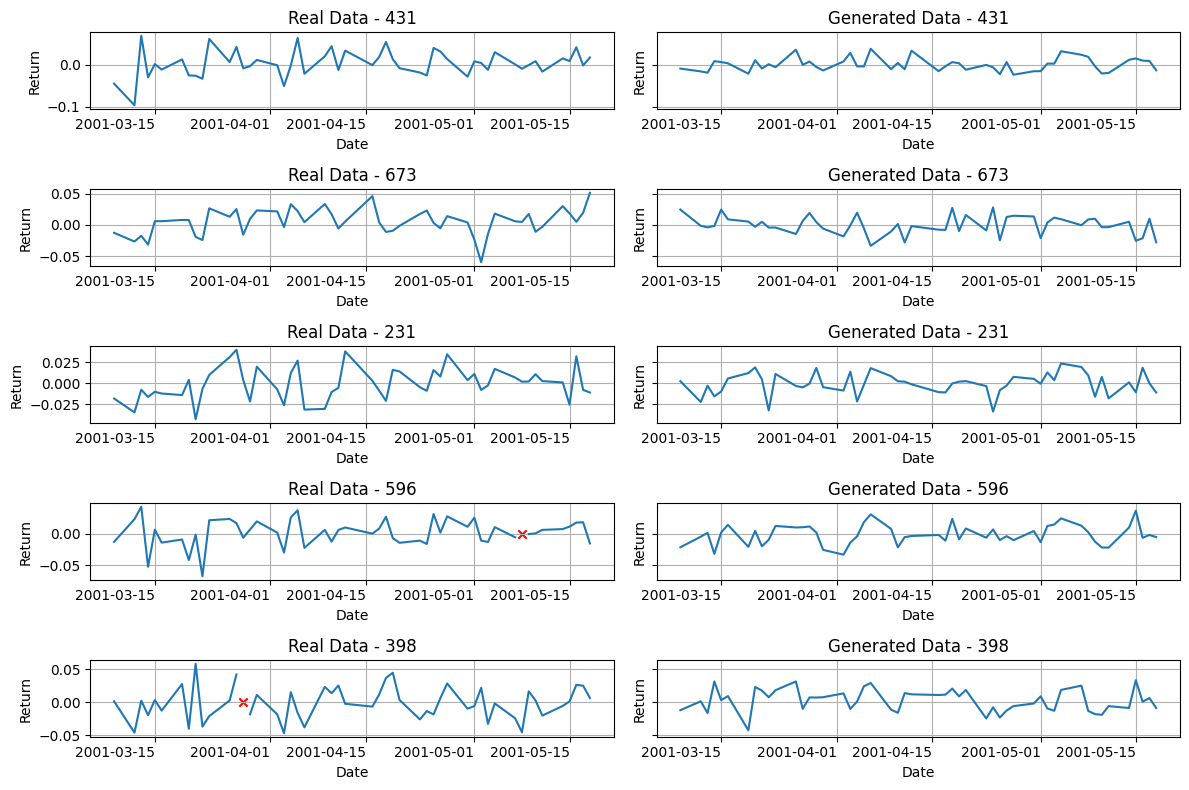

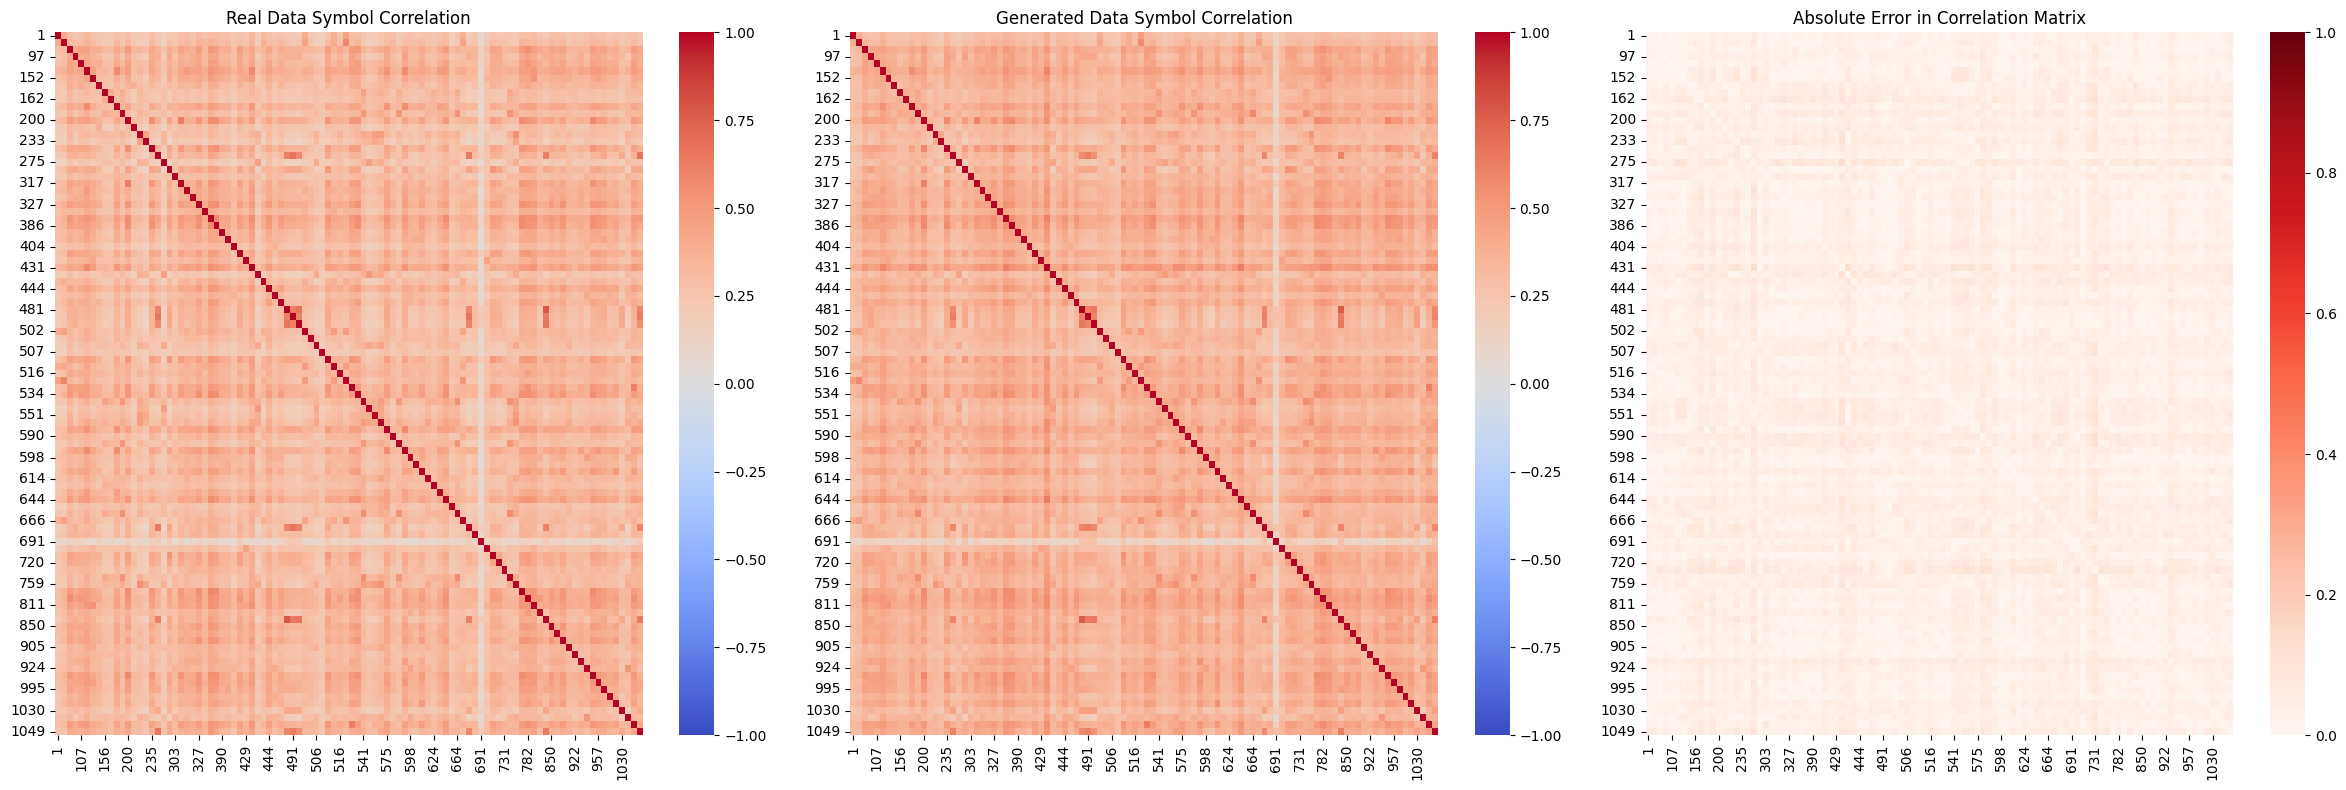

Mean absolute correlation difference: 0.0354
Correlation between correlation matrices: 0.9699
Max absolute error in correlations: 0.1381
Median absolute error in correlations: 0.0333


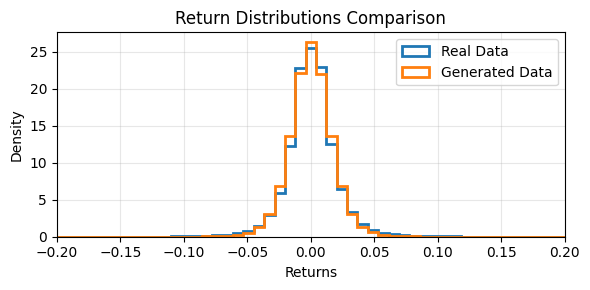

Distribution Statistics:
Real data - Mean: 0.000554, Std: 0.020648
Generated data - Mean: 0.000066, Std: 0.017368
Kolmogorov-Smirnov test - Statistic: 0.0199, p-value: 0.000000


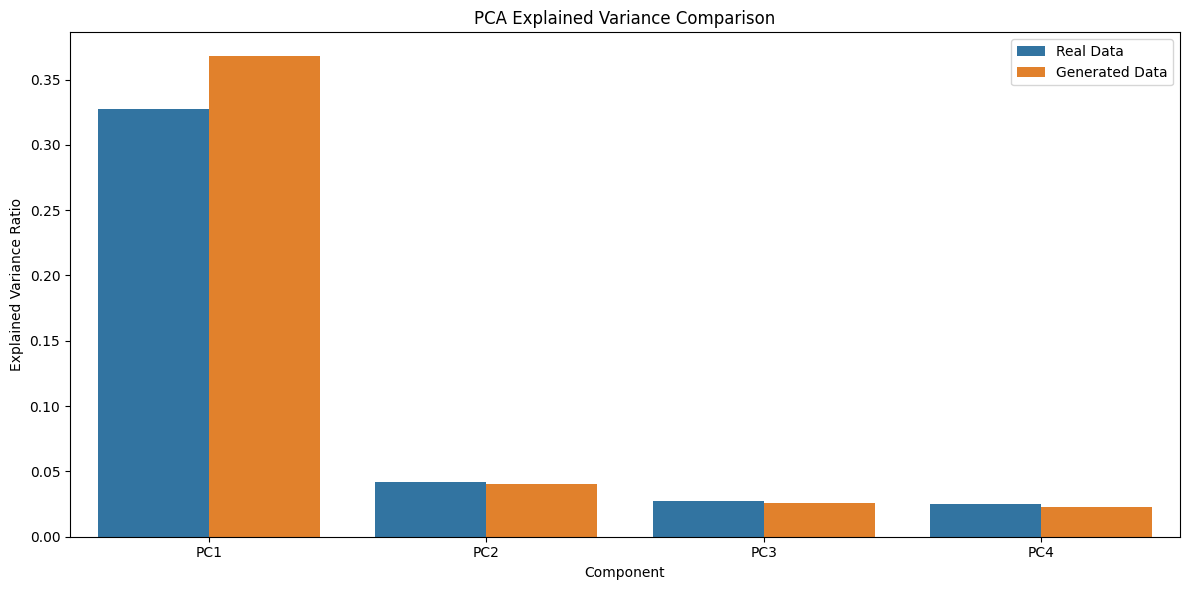

PCA Explained Variance:
Real data: [0.3275 0.0418 0.0277 0.0249]
Generated data: [0.3678 0.0404 0.0257 0.0227]
Total explained variance (first 4 components):
Real data: 0.4218 (42.2%)
Generated data: 0.4566 (45.7%)


In [14]:
analyze_financial_data(df_true, df_sample, num_symbols_to_show=df.shape[1])